In [1]:
# импорт библиотек

import numpy as np
import pandas as pd
import json
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # отображение всех ячеек Jupyter ноутбука на всю ширину окна браузера
from pathlib import Path
import shutil
import os
from tqdm import tqdm, trange
import cv2
import copy
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import colorsys
from PIL import Image
from tabulate import tabulate
from collections import OrderedDict

# Функции и классы

In [15]:
class DatasetBalanceParser():
        
    '''
    Класс парсера, отбирающего для датасетов моделей Yolo максимально возможно сбалансированную выборку образцов
    по кол-ву объектов на каждый класс до заданного порога по количеству объектов
    '''
    
    
    def __init__(self, classes_names_list, source_annotations_path, source_images_path):
        self.classes_names_list = classes_names_list
        self.source_annotations_path = source_annotations_path
        self.source_images_path = source_images_path
        self.avoid_file_names_list = []
        self.avoid_file_names_list_backup_copy = []
        
    def calculate_dataset_info(self, classes_names_list, annotations_path, file_names_list=None, source_dataset=False, calculate_dataset_size=True):
        
        '''
        Возвращает словари со статистиками по датасету
        '''
                
        num_classes = len(classes_names_list)

        classes_objects_count_DICT = {}
        classes_images_count_DICT = {}
        classes_file_names_lists_DICT = {}
        for class_idx in range(num_classes):
            classes_objects_count_DICT.update({class_idx: 0})
            classes_images_count_DICT.update({class_idx: 0})
            classes_file_names_lists_DICT.update({class_idx: []})

        if file_names_list is not None:
            annotations_file_names_list = file_names_list
            dataset_images_num = None
            annotations_path = self.source_annotations_path
        else:
            annotations_file_names_list = os.listdir(annotations_path)

        for filename in annotations_file_names_list:
            if (file_names_list is not None) and ('_repeat_' in filename):
                filename = filename.split('_repeat_')[0] + '.' + filename.split('.')[1]
            with open(annotations_path/filename, 'rt') as annotation_file:
                current_bbox_classes_list = []
                for bbox_data in annotation_file:
                    current_class_idx = int(bbox_data[0])
                    classes_objects_count_DICT[current_class_idx] += 1
                    if current_class_idx not in current_bbox_classes_list:
                        current_bbox_classes_list.append(current_class_idx)
                for class_idx in current_bbox_classes_list:
                    classes_images_count_DICT[class_idx] += 1
                    classes_file_names_lists_DICT[class_idx].append(filename)
            dataset_images_num = len(annotations_file_names_list)
        
        if source_dataset and calculate_dataset_size:
            images_file_names_list = os.listdir(self.source_images_path)
            dataset_size = 0
            for filename in images_file_names_list:
                if filename.split('.')[1] not in ['jpg', 'JPG', 'png', 'PNG']:
                    pass
                dataset_size += os.path.getsize(self.source_images_path/filename)
            dataset_size = dataset_size / 1024 / 1024

            return classes_objects_count_DICT, classes_images_count_DICT, classes_file_names_lists_DICT, dataset_images_num, dataset_size
        
        elif not source_dataset and calculate_dataset_size:       
            annotation_filenames_whithout_ext = [filename[:-4] for filename in annotations_file_names_list]
            images_file_names_list = [filename for filename in os.listdir(self.source_images_path) if filename[:-4] in annotation_filenames_whithout_ext]
            dataset_size = 0
            for filename in images_file_names_list:
                dataset_size += os.path.getsize(self.source_images_path/filename)
            dataset_size = dataset_size / 1024 / 1024

            return classes_objects_count_DICT, classes_images_count_DICT, classes_file_names_lists_DICT, dataset_images_num, dataset_size
        
        elif not calculate_dataset_size:
            
            dataset_size = None
            return classes_objects_count_DICT, classes_images_count_DICT, classes_file_names_lists_DICT, dataset_images_num, dataset_size

    
    def plot_dataset_classes_info(self, headers, classes_names_list, classes_objects_count_DICT, classes_images_count_DICT, dataset_images_num, dataset_size, show_source_dataset_remaining_classes_info=False):
        
        '''
        Печать статистик по датасету в таблицу, включая вывод данных
        '''
        
        def statistics_table_data(classes_names_list, classes_objects_count_DICT, classes_images_count_DICT, dataset_images_num, dataset_size):
            
            classes_info_display_list = []
            for class_key in range(num_classes):
                class_info_list = []
                class_info_list.append(classes_names_list[class_key])
                class_info_list.append(classes_objects_count_DICT[class_key])
                class_num_images = class_info_list.append(classes_images_count_DICT[class_key])
                classes_info_display_list.append(class_info_list)        

            classes_display_headers = ['\nНазвание класса', 'Количество объектов\nпо классам', 'Общее количество\nизображений по классам']
            print(tabulate(classes_info_display_list, headers=classes_display_headers, tablefmt='presto'))
            print()
            total_classes_objects_num = f'Общее количество объектов по всем классам: {sum(classes_objects_count_DICT.values())}'
            total_images_num = f'Общее количество изображений: {dataset_images_num}'
            selected_dataset_size = f'Размер изображений датасета: {dataset_size:,.1f} Мб'
            dash_line = len(total_classes_objects_num)*'-'
            print(dash_line, total_classes_objects_num, total_images_num, selected_dataset_size, dash_line, sep='\n')        
            print()        
        
        def plot_diagram(diagram_colors, header):
            plt.rcParams.update({'font.size': 8})
            colors = [[255, 0, 0], [255, 69, 0], [255, 140, 0], [60, 179, 113], [0, 0, 255], [128, 0, 128], [255, 0, 255]]        
            plt.figure(figsize=(5, 4), facecolor=diagram_colors[0])
            plt.subplot(fc=diagram_colors[1])
            plt.title(header, fontsize=8)
            classes_colors_list = [(color[0]/255, color[1]/255, color[2]/255) for color in colors]
            classes_objects_num = [class_objects_num for class_objects_num in classes_objects_count_DICT.values()]
            plt.bar([f'class_{class_idx}' for class_idx in range(num_classes)], classes_objects_num, width=0.7, color=classes_colors_list, edgecolor='black')
            plt.grid()
            #plt.yticks(np.arange(0, math.ceil(max(classes_objects_num)), 1000*round(max(classes_objects_num)/1000/20)))
            plt.ylabel('Количество объектов в классе')

            handles = [plt.Rectangle((0,0),1,1, color=classes_colors_list[class_idx]) for class_idx in range(num_classes)]
            legend = plt.legend(handles, classes_names_list, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, framealpha=0)
            legend.set_title('Названия классов')
            plt.show()
            print()
        
        print()
        header = headers[0]
        dot_line = len(header)*'*'
        print(dot_line, header, dot_line, sep='\n')
        print()
        
        num_classes = len(classes_names_list)
        
        statistics_table_data(classes_names_list, classes_objects_count_DICT, classes_images_count_DICT, dataset_images_num, dataset_size)
        plot_diagram(('deepskyblue', 'lightgoldenrodyellow'), headers[1])
        
        if show_source_dataset_remaining_classes_info:
            print()
            header = headers[2]
            dot_line = len(header)*'*'
            print(dot_line, header, dot_line, sep='\n')
            print()
            
            remaining_objects_file_names_list = [filename for filename in os.listdir(self.source_annotations_path) if filename not in self.avoid_file_names_list]
            classes_objects_count_DICT, classes_images_count_DICT, _, dataset_images_num, dataset_size =\
            self.calculate_dataset_info(classes_names_list, None, file_names_list=remaining_objects_file_names_list)
            
            plot_diagram(('lightpink', 'lightgoldenrodyellow'), headers[3])
            statistics_table_data(classes_names_list, classes_objects_count_DICT, classes_images_count_DICT, dataset_images_num, dataset_size)
            
                    
    def source_dataset_info(self):        
        classes_objects_count_DICT, classes_images_count_DICT, _, dataset_images_num, dataset_size =\
        self.calculate_dataset_info(self.classes_names_list, self.source_annotations_path, source_dataset=True)
        
        self.plot_dataset_classes_info(['Статистика исходного датасета', 'Диаграмма количества объектов по классам в исходном датасете'],
                                       self.classes_names_list,
                                       classes_objects_count_DICT,
                                       classes_images_count_DICT,
                                       dataset_images_num,
                                       dataset_size)
        
        classes_objects_count_LIST = []
        for class_idx in range(len(self.classes_names_list)):
            classes_objects_count_LIST.append(classes_objects_count_DICT[class_idx])
        
        return classes_objects_count_LIST
        
    def balanced_dataset_info(self, target_annotations_path, balanced_classes_file_names_list):
        classes_objects_count_DICT, classes_images_count_DICT, _, dataset_images_num, dataset_size =\
        self.calculate_dataset_info(self.classes_names_list, target_annotations_path, file_names_list=balanced_classes_file_names_list)
        
        self.plot_dataset_classes_info(['Статистика отобранной из датасета выборки',
                                        'Диаграмма количества объектов по классам отобранной из датасета выборки',
                                        'Статистика по оставшимся объектам классов в исходном датасете',
                                        'Диаграмма количества оставшихся объектов по классам в исходном датасете'],
                                       self.classes_names_list,
                                       classes_objects_count_DICT,
                                       classes_images_count_DICT,
                                       dataset_images_num,
                                       dataset_size,
                                       show_source_dataset_remaining_classes_info=True)
    
    
    def copy_selected_dataset_files(self, file_names_list, source_path, target_path):
        '''
        функция копирования файлов датасета по заданному списку в заданную директорию с отловом ошибок копирования
        Копирует файлы из поданного списка file_names_list из исходной папки source_path в заданную папку target_path.
        Возвращает кол-во успешно скопированных файлов total_ok и общий список имен файлов нескопированных из-за любой ошибки.
        
        ПРИМЕЧАНИЕ. Данный метод для копирования в режиме оверсамплинга с повторением файлов с суффиксом _repeat_ и кол-вом повторов файла не апгрейдил за ненадобностью.
        Если нужно будет копировать файлы в режиме оверсамплинга, нужно будет дополнить код.
        '''
        total_ok = 0
        file_not_found_file_names_list = []
        total_failed_file_names_list = []
        bar_format = 'Прогресс копирования: {bar:25} копирование файла {n_fmt} из {total_fmt}, время осталось {remaining} мин:сек'
        for filename in tqdm(file_names_list, position=0, leave=True, bar_format=bar_format):
            try:
                shutil.copy(source_path / filename, target_path)
                total_ok += 1
            except Exception:
                total_failed_file_names_list.append(filename)
                continue
        return total_ok, total_failed_file_names_list    
    
        
    def get_balanced_samples(self, class_objects_threshold, target_annotations_path, initial_avoid_file_names_list=None, keep_avoided=True, analysys_mode=False, oversampling_classes=[]):
        
        '''
        Выполняет отбор образцов до сбалансированного значения по объектам каждого класса
        Копирование отобранных образцов в заданную папку с выводом статистик полученной сбалансированной выборки
        '''

        def class_objects_count(annotations_path, file_names_list):
            '''
            Функция подсчета количества объектов в поданом списке файлов
            '''
            class_objects_num = 0
            for filename in file_names_list:
                if '_repeat_' in filename:
                    filename = filename.split('_repeat_')[0] + '.' + filename.split('.')[1]
                with open(annotations_path/filename, 'rt') as annotation_file:
                    for bbox_data in annotation_file:
                        current_class_idx = int(bbox_data[0])                
                        if current_class_idx == class_idx:
                            class_objects_num += 1
            return class_objects_num

        def indexes_selection(images_estimation_num, images_selection_step):
            '''
            Функция получения списка индексов для отбора файлов
            '''
            selection_indexes_list = []
            selection_index = 0
            images_selection_step_summ = 0
            for i in range(images_estimation_num):
                selection_indexes_list.append(selection_index)
                images_selection_step_summ += images_selection_step
                selection_index = math.floor(images_selection_step_summ)
            return selection_indexes_list

        classes_objects_count_DICT, classes_images_count_DICT, source_dataset_classes_file_names_lists_DICT, dataset_images_num, _ = self.calculate_dataset_info(self.classes_names_list, self.source_annotations_path, calculate_dataset_size=False)
        
        sorted_classes_objects_count_DICT = OrderedDict(sorted(classes_objects_count_DICT.items(), key=lambda item: item[1]))
        
        if initial_avoid_file_names_list:
            self.avoid_file_names_list = initial_avoid_file_names_list        
        
        balanced_classes_file_names_list = [] # хранилище для файлов сбалансированной выборки
        
        for item in sorted_classes_objects_count_DICT.items():

            if item[1] == 0:
                continue # отсекаем в данном датасете классы без объектов
                
            if type(class_objects_threshold) == int:
                current_class_objects_threshold = class_objects_threshold #единый порог по объектам для всех классов
            else:
                current_class_objects_threshold = class_objects_threshold[item[0]] #берем порог для текущего класса
                
            class_idx = item[0]

                                    
            if class_idx in oversampling_classes:                        
                class_existing_objects_num = class_objects_count(self.source_annotations_path, balanced_classes_file_names_list)
                selected_class_objects_num = class_existing_objects_num
                available_class_file_names_list = source_dataset_classes_file_names_lists_DICT[class_idx]
                available_class_images_num = len(available_class_file_names_list)
                available_class_objects_num = class_objects_count(self.source_annotations_path, available_class_file_names_list)
                needed_class_objects_num = current_class_objects_threshold - class_existing_objects_num #selected_class_objects_num
                
                average_class_objects_per_image = available_class_objects_num/available_class_images_num
                needed_images_estimation_num = math.ceil(needed_class_objects_num/average_class_objects_per_image)
                selected_class_file_names_list = []
                filenames_repeat_count_DICT = {}
                for i in range(needed_images_estimation_num):
                    filename = random.choice(available_class_file_names_list)
                    if filename not in filenames_repeat_count_DICT.keys():
                        filenames_repeat_count_DICT[filename] = 0
                        selected_class_file_names_list.append(filename)
                    elif filename in filenames_repeat_count_DICT.keys():
                        filenames_repeat_count_DICT[filename] += 1
                        filename = filename.split('.')[0] + '_repeat_' + str(filenames_repeat_count_DICT[filename]) + '.' +  filename.split('.')[1]
                        selected_class_file_names_list.append(filename)
                selected_class_objects_num += class_objects_count(self.source_annotations_path, selected_class_file_names_list)
                while selected_class_objects_num < current_class_objects_threshold: #если объектов меньше порога, то добавляем по одному пока не достигнем порога
                    filename = random.choice(available_class_file_names_list)
                    if filename not in filenames_repeat_count_DICT.keys():
                        filenames_repeat_count_DICT[filename] = 0
                        selected_class_file_names_list.append(filename)
                    elif filename in filenames_repeat_count_DICT.keys():
                        filenames_repeat_count_DICT[filename] += 1
                        filename = filename.split('.')[0] + '_repeat_' + str(filenames_repeat_count_DICT[filename]) + '.' +  filename.split('.')[1]
                        selected_class_file_names_list.append(filename)
                    selected_class_objects_num = class_existing_objects_num + class_objects_count(self.source_annotations_path, selected_class_file_names_list)
                #print(f'Класс {classes_names_list[class_idx]}', '- режим oversampling')
                #print(f'class_existing_objects_num = {class_existing_objects_num}', '|', f'class_objects_threshold = {current_class_objects_threshold}')
                    
            else:
                class_existing_objects_num = class_objects_count(self.source_annotations_path, balanced_classes_file_names_list)
                if class_existing_objects_num >= current_class_objects_threshold:
                    selected_class_file_names_list = []
                selected_class_objects_num = class_existing_objects_num
                first_attempt = True
                while selected_class_objects_num < current_class_objects_threshold:    
                    if first_attempt:

                        # получаем список файлов доступных для отбора (без уже ранее отобранных из списка avoid_file_names_list, чтобы исключить повторения)
                        available_class_file_names_list = [file_name for file_name in source_dataset_classes_file_names_lists_DICT[class_idx] if file_name not in self.avoid_file_names_list]    
                        available_class_images_num = len(available_class_file_names_list)

                        # считаем количество объектов отбираемого класса в доступных для отбора файлах
                        available_class_objects_num = class_objects_count(self.source_annotations_path, available_class_file_names_list)
                        if available_class_objects_num + class_existing_objects_num < current_class_objects_threshold:
                            print()
                            header = f'Уменьшите пороговое значение, для класса {self.classes_names_list[class_idx]}, количество объектов в неиспользованных для отбора файлах менее заданного порога'
                            dot_line = len(header)*'*'
                            print(dot_line, header, dot_line, sep='\n')
                            print()
                            
                            self.avoid_file_names_list = self.avoid_file_names_list_backup_copy
                            
                            return

                        needed_class_objects_num = current_class_objects_threshold - selected_class_objects_num
                        average_class_objects_per_image = available_class_objects_num/available_class_images_num
                        needed_images_estimation_num = math.ceil(needed_class_objects_num/average_class_objects_per_image)
                        estimated_images_selection_step = available_class_images_num/needed_images_estimation_num

                        # отбираем индексы выбора файлов из available_class_file_names_list суммированием и округлением оценочного шага
                        selection_indexes_list = indexes_selection(needed_images_estimation_num, estimated_images_selection_step)

                        selected_class_file_names_list = list(np.asarray(available_class_file_names_list)[selection_indexes_list])
                        selected_class_objects_num += class_objects_count(self.source_annotations_path, selected_class_file_names_list)
                        first_attempt = False

                    else: # если не хватает объектов до заданного порога, добавляем по одному количество файлов изображений и делаем повторный рассчет
                        needed_images_estimation_num += 1
                        estimated_images_selection_step = available_class_images_num/needed_images_estimation_num

                        # повторно отбираем индексы выбора файлов из available_class_file_names_list суммированием и округлением оценочного шага
                        selection_indexes_list = indexes_selection(needed_images_estimation_num, estimated_images_selection_step)

                        selected_class_file_names_list = list(np.asarray(available_class_file_names_list)[selection_indexes_list])
                        selected_class_objects_num = class_existing_objects_num + class_objects_count(self.source_annotations_path, selected_class_file_names_list)
                #print(f'Класс {classes_names_list[class_idx]}', '- режим selection')
                #print(f'class_existing_objects_num = {class_existing_objects_num}', '|', f'class_objects_threshold = {current_class_objects_threshold}')
                        
            #print('selected_class_file_names_list:', len(selected_class_file_names_list))
            
            self.avoid_file_names_list.extend(selected_class_file_names_list)
            self.avoid_file_names_list = list(set(self.avoid_file_names_list))
            
            #print('self.avoid_file_names_list:', len(self.avoid_file_names_list))

            balanced_classes_file_names_list.extend(selected_class_file_names_list)
            
            #print('balanced_classes_file_names_list:', len(balanced_classes_file_names_list))
            #print()
        
        self.avoid_file_names_list_backup_copy = self.avoid_file_names_list.copy()
        
        if not keep_avoided:
            self.avoid_file_names_list = []
        
        if not analysys_mode:
            total_ok, total_failed_file_names_list = \
            self.copy_selected_dataset_files(balanced_classes_file_names_list, 
                                        self.source_annotations_path, 
                                        target_annotations_path)

            self.balanced_dataset_info(target_annotations_path, None)
        else:
            self.balanced_dataset_info(None, balanced_classes_file_names_list)
            
    def reset_avoided(self):
        self.avoid_file_names_list = []

In [30]:
def copy_selected_dataset_files(file_names_list, source_path, target_path, summary=True):
    
    '''
    функция копирования файлов датасета по заданному списку в заданную директорию с отловом ошибок копирования
    
    Функция копирует файлы из поданного списка file_names_list из исходной папки source_path в заданную папку target_path.
    Возвращает кол-во успешно скопированных файлов total_ok,
    отдельный список имен файлов file_not_found_file_names_list с ошибкой fileNotFoundError
    и общий список имен файлов нескопированных из-за любой ошибки.
    '''
    
    def dataset_files_copy_summary(total_ok, file_not_found_file_names_list, total_failed_file_names_list):
        '''
        функция вывода отчета по результатам копирования

        '''    
        print()
        header = 'Результаты копирования'
        print(header, '-'*len(header), sep='\n')
        print(f'Всего успешно скопированых файлов: {total_ok}')
        print(f'Всего файлов не скопировавшиеся в связи с ошибкой "Файл не найден": {len(file_not_found_file_names_list)}')
        if file_not_found_file_names_list:
            print(file_not_found_file_names_list)
        print(f'Всего не скопировавшихся файлов: {len(total_failed_file_names_list)}')
        if total_failed_file_names_list:
            print(total_failed_file_names_list)
        print()
        
    total_ok = 0
    file_not_found_file_names_list = []
    total_failed_file_names_list = []
    bar_format = 'Прогресс копирования: {bar:25} копирование файла {n_fmt} из {total_fmt}, время осталось {remaining} мин:сек.'
    for file_name in tqdm(file_names_list, position=0, leave=True, bar_format=bar_format):
        try:
            shutil.copy(source_path / file_name, target_path)
            total_ok += 1
        except FileNotFoundError:
            file_not_found_file_names_list.append(file_name)
            total_failed_file_names_list.append(file_name)
            continue
        except Exception:
            total_failed_file_names_list.append(file_name)
            continue
    
    if summary:
        dataset_files_copy_summary(total_ok, file_not_found_file_names_list, total_failed_file_names_list)    
    
    return total_ok, file_not_found_file_names_list, total_failed_file_names_list 

# Статистика составного датасета Combined_v6_AFO_Sharks_final

In [64]:
# Глобальные переменные

Combined_source_dataset_annotations_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Combined_v6_AFO_Sharks_final\labels')
Combined_source_dataset_images_path = Path(r'e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Combined_v6_AFO_Sharks_final\images')
datasets_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты')
classes_names_list = ['0_person_water', '1_person_water_vest', '2_person_boat', '3_person_boat_vest', '4_boat', '5_barrier', '6_shark']

In [74]:
# Создание класса парсера для датасета Combined_v6_AFO_Sharks_final

Combined_balanceParser = DatasetBalanceParser(classes_names_list, Combined_source_dataset_annotations_path, Combined_source_dataset_images_path)


*****************************
Статистика исходного датасета
*****************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 31958 |                     8573
 1_person_water_vest |                 30956 |                     9085
 2_person_boat       |                 13062 |                     6547
 3_person_boat_vest  |                  8598 |                     4098
 4_boat              |                 24702 |                    14078
 5_barrier           |                  1659 |                      921
 6_shark             |                  2628 |                     1796

-------------------------------------------------
Общее количество объектов по всем классам: 113563
Общее количество изображений: 21361
Размер изображений датасета: 8,887.9 Мб
----------

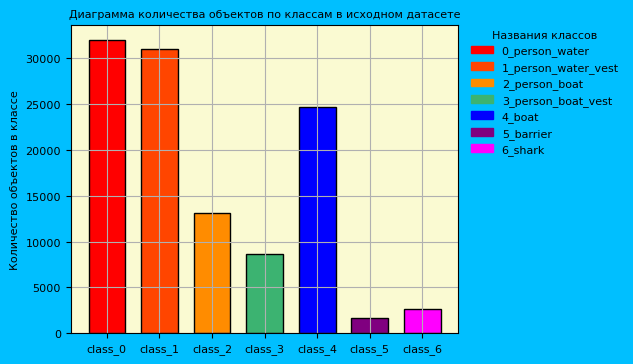

In [75]:
# Статистика составного датасета Combined_v6_AFO_Sharks_final

'''
Вызов метода source_dataset_info() для вывода статистики по количеству объектов каждого класса, 
количеству изображений и их размеру в Мб в датасете Combined_v6_AFO_Sharks_final

'''

source_dataset_classes_objects_count_LIST = Combined_balanceParser.source_dataset_info()

# Статистика датасета MOBDrone и отбор балансирующим парсером выборки из MOBDrone в итоговый датасет

In [6]:
# Глобальные переменные

MOBDrone_source_dataset_annotations_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\MOBDrone_dataset\yolov5_annotations_project_classes')
MOBDrone_source_dataset_images_path = Path(r'e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\MOBDrone_dataset\images_with_objects_JPG')
MOBDrone_datasets_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты')
classes_names_list = ['0_person_water', '1_person_water_vest', '2_person_boat', '3_person_boat_vest', '4_boat', '5_barrier', '6_shark']

In [7]:
# Создание класса парсера для датасета MOBDrone

MOBDrone_balanceParser = DatasetBalanceParser(classes_names_list, MOBDrone_source_dataset_annotations_path, MOBDrone_source_dataset_images_path)


*****************************
Статистика исходного датасета
*****************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                107901 |                    75256
 1_person_water_vest |                     0 |                        0
 2_person_boat       |                  5507 |                     3734
 3_person_boat_vest  |                     0 |                        0
 4_boat              |                 41899 |                    31260
 5_barrier           |                     0 |                        0
 6_shark             |                     0 |                        0

-------------------------------------------------
Общее количество объектов по всем классам: 155307
Общее количество изображений: 91193
Размер изображений датасета: 31,781.5 Мб
---------

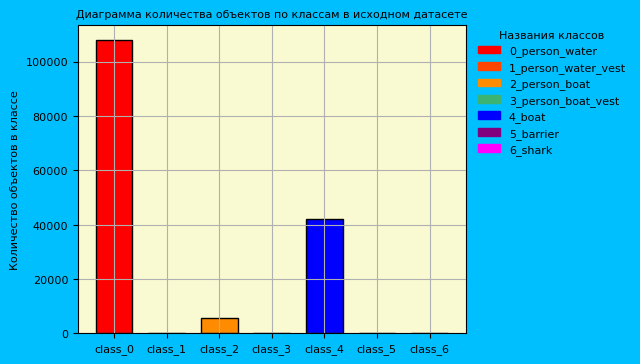

In [81]:
# Вывод статистики датасета MOBDrone

'''
Вызов метода source_dataset_info() для вывода статистики по количеству объектов каждого класса, кол-ву изображений и их размеру в Мб в датасете MOBDrone

'''

source_dataset_classes_objects_count_LIST = MOBDrone_balanceParser.source_dataset_info()

In [8]:
# Папка для копирования отобранных файлов аннотаций из MOBDrone в общий итоговый датасет

MOBDrone_selected_annotations_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\MOBDrone_dataset\selected_annotations_for_total_dataset')

In [17]:
MOBDrone_balanceParser.reset_avoided()

Прогресс копирования: █████████████████████████ копирование файла 6233 из 6233, время осталось 0



*********************************************
Статистика сформированной выборки из датасета
*********************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                  7004 |                     4125
 1_person_water_vest |                     0 |                        0
 2_person_boat       |                  5507 |                     3734
 3_person_boat_vest  |                     0 |                        0
 4_boat              |                  9843 |                     4248
 5_barrier           |                     0 |                        0
 6_shark             |                     0 |                        0

------------------------------------------------
Общее количество объектов по всем классам: 22354
Общее количество изображений: 6233
Разме

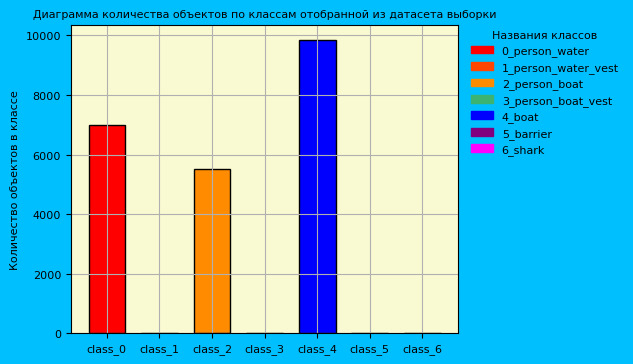



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



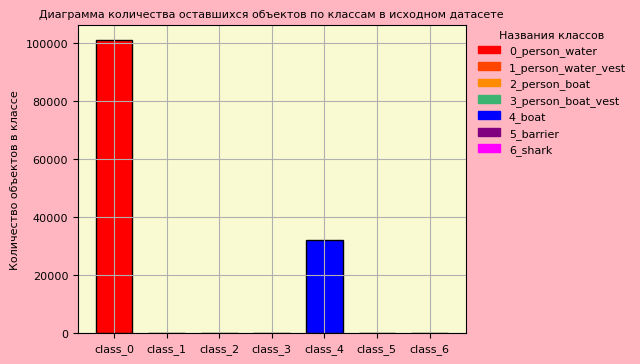


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                100897 |                    71131
 1_person_water_vest |                     0 |                        0
 2_person_boat       |                     0 |                        0
 3_person_boat_vest  |                     0 |                        0
 4_boat              |                 32056 |                    27012
 5_barrier           |                     0 |                        0
 6_shark             |                     0 |                        0

-------------------------------------------------
Общее количество объектов по всем классам: 132953
Общее количество изображений: 84960
Размер изображений датасета: 28,944.7 Мб
-------------------------------------------------



In [18]:
# После просмотра статистики выше парсером отбираем выборку из датасета MOBDrone по классам 0, 2 и 4 с порогами по количеству объектов 7000, 5507, 7000 соответственно
# В классе 2 отбираем все изображения (т.к. задан порог с максимальным количеством объектов 5507)

'''
На синем графике показано статистика выборки, которая получилась в результате отбора с порогами [7000, 0, 5507, 0, 7000, 0, 0].
На красном графике показано сколько еще можно отобрать объектов из датасета за минусом уже отобранных (т.е. сколько объектов еще осталось полсе извлечения выборки с заданными порогами по каждому классу)
Файлы отобранной выборки копируются в папку MOBDrone_selected_annotations_path
Для обоих выборок отобранной и оставшейся отображаются статистики по кол-ву объектов, изображений и размеру в Мб.
'''

MOBDrone_balanceParser.get_balanced_samples([7000, 0, 5507, 0, 7000, 0, 0],
                                            MOBDrone_selected_annotations_path,
                                            initial_avoid_file_names_list=None,
                                            keep_avoided=True,
                                            analysys_mode=False)

In [85]:
# Папка для копирования изображений из датасета MOBDrone в соответствии с отобранными парсером аннотациями

MOBDrone_selected_images_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\MOBDrone_dataset\selected_images_for_total_dataset')

In [86]:
# Копирование файлов изображений выборки из исходного датасета MOBDrone в собственную папку images

'''
После отбора парсером максимально сбалансированной выборки с заданными порогами по классам из MOBDrone,
по отобранным аннотациям производится копирование соответствующих изображений в папку изображений формируемой сбалансированной выборки 
'''

MOBDrone_selected_images_file_names_list = [filename.rstrip('.txt') + '.jpg' for filename in os.listdir(MOBDrone_selected_annotations_path)]
_, _, _ = copy_selected_dataset_files(MOBDrone_selected_images_file_names_list,
                                      MOBDrone_source_dataset_images_path,
                                      MOBDrone_selected_images_path, 
                                      summary=True)

Прогресс копирования: █████████████████████████ копирование файла 6233 из 6233, время осталось 00:00 мин:сек.


Результаты копирования
----------------------
Всего успешно скопированых файлов: 6233
Всего файлов не скопировавшиеся в связи с ошибкой "Файл не найден": 0
Всего не скопировавшихся файлов: 0



# Статистика финального датасета Total_dataset (Combined_v6_AFO_Sharks_final + полученная выборка из MOBDrone)

In [ ]:
'''
После формирования отобранной парсером выборки с заданными порогами из MOBDrone (изображений и аннотаций), 
ее файлы изображений и аннотаций совмещены с датасетом Combined_v6_AFO_Sharks_final и получен итоговый датасет Total_dataset
'''

In [23]:
# Глобальные переменные

Total_source_dataset_annotations_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Total_dataset\labels')
Total_source_dataset_images_path = Path(r'e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Total_dataset\images')
datasets_path = Path('e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты')
classes_names_list = ['0_person_water', '1_person_water_vest', '2_person_boat', '3_person_boat_vest', '4_boat', '5_barrier', '6_shark']

In [24]:
# Создание экземпляра парсера для Total_dataset

Total_balanceParser = DatasetBalanceParser(classes_names_list, Total_source_dataset_annotations_path, Total_source_dataset_images_path)


*****************************
Статистика исходного датасета
*****************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 38962 |                    12698
 1_person_water_vest |                 30956 |                     9085
 2_person_boat       |                 18569 |                    10281
 3_person_boat_vest  |                  8598 |                     4098
 4_boat              |                 34545 |                    18326
 5_barrier           |                  1659 |                      921
 6_shark             |                  2628 |                     1796

-------------------------------------------------
Общее количество объектов по всем классам: 135917
Общее количество изображений: 27594
Размер изображений датасета: 11,724.7 Мб
---------

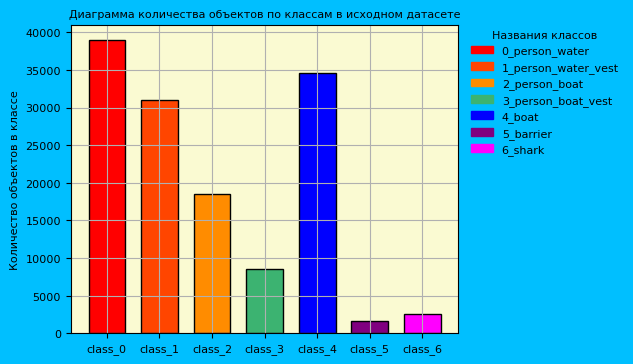

In [25]:
# Вывод статистики Total_dataset

Total_dataset_classes_objects_count_LIST = Total_balanceParser.source_dataset_info()

# Получение стратифицированных train и val выборок из Total_dataset с предельно одинаковым соотношением объектов по классам как в train так и в val выборке

In [26]:
# Папка в которую будут перемещены отобранные парсером аннотации val выборки

Total_val_labels_path = Path(r'e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Total_dataset\val_labels')

In [27]:
# Рассчет количества объектов на класс для проверочной выборки в размере 20% от количества объектов по каждому классу от количества в исходном датасете

val_total_dataset_classes_objects_count_LIST = []
val_rate = 0.2

for class_objects_num in Total_dataset_classes_objects_count_LIST:
    val_total_dataset_classes_objects_count_LIST.append(round(class_objects_num*val_rate))

val_total_dataset_classes_objects_count_LIST #список из порогов количества объектов на класс проверочной выборки

[7792, 6191, 3714, 1720, 6909, 332, 526]

Прогресс копирования: █████████████████████████ копирование файла 5125 из 5125, время осталось 0



*****************************************
Статистика отобранной из датасета выборки
*****************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                  7924 |                     2367
 1_person_water_vest |                  7713 |                     1971
 2_person_boat       |                  4744 |                     2548
 3_person_boat_vest  |                  2531 |                     1212
 4_boat              |                  7586 |                     3852
 5_barrier           |                   438 |                      238
 6_shark             |                   619 |                      443

------------------------------------------------
Общее количество объектов по всем классам: 31555
Общее количество изображений: 5125
Размер изображени

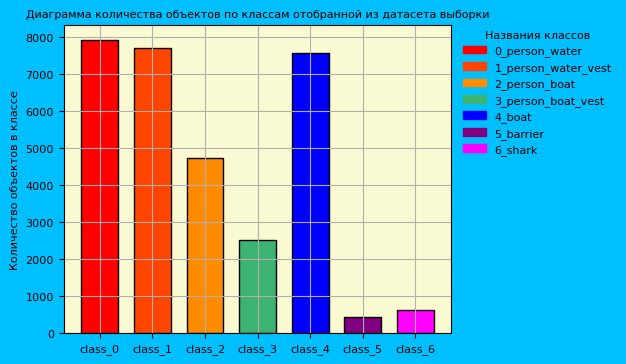



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



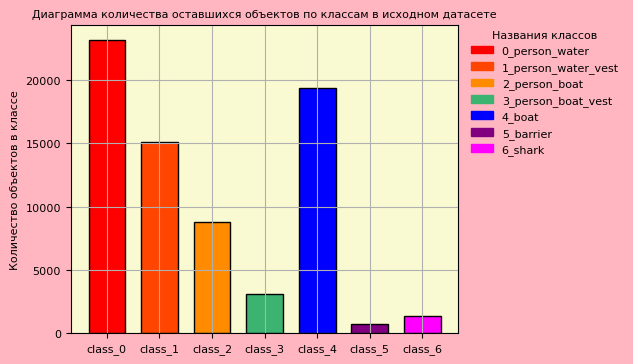


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 23129 |                     8016
 1_person_water_vest |                 15069 |                     5103
 2_person_boat       |                  8808 |                     5052
 3_person_boat_vest  |                  3141 |                     1479
 4_boat              |                 19338 |                    10621
 5_barrier           |                   769 |                      443
 6_shark             |                  1358 |                      879

------------------------------------------------
Общее количество объектов по всем классам: 71612
Общее количество изображений: 17532
Размер изображений датасета: 7,358.1 Мб
------------------------------------------------



In [29]:
# Отбор парсером стратифицированной val выборки размером 20% с максимально возможным аналогичным соотношением количеством объектов на класс, как и в исходном датасете
# и копирование парсером отобранных аннотаций val выборки в отдельную папку

Total_balanceParser.get_balanced_samples([7792, 6191, 3714, 1720, 6909, 332, 526],
                                         Total_val_labels_path,
                                         initial_avoid_file_names_list=None,
                                         keep_avoided=True,
                                         analysys_mode=False)

'''
Ниже показана статистика получившейся val выборки на синем графике, а на розовом графике показа статистика оставшейся train выборки.
Количества объектов на класс между val и train выборками максимально пропорциональны между собой, дисбаланс может наблюдаться только по единичным мажорным классам.
Парсер помнит уже отобранные файлы и не отберет их повторно, далее парсером можно отобрать и скопировать train выборку в отдельную папку.
'''

In [32]:
# Папка в которую будут перемещены отобранные парсером аннотации train выборки

Total_train_labels_path = Path(r'e:\Образование\Учеба УИИ\Стажировки УИИ\Стажировка 1 - квадрокоптер\Датасеты\Total_dataset\train_labels')

In [33]:
# Пороги по объектам на класс для train выборки, взятые из статистики выше

train_total_dataset_classes_objects_count_LIST = [23129, 15069, 8808, 3141, 19338, 769, 1358]

Прогресс копирования: █████████████████████████ копирование файла 17525 из 17525, время осталось



*****************************************
Статистика отобранной из датасета выборки
*****************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 23129 |                     8016
 1_person_water_vest |                 15069 |                     5103
 2_person_boat       |                  8808 |                     5052
 3_person_boat_vest  |                  3141 |                     1479
 4_boat              |                 19338 |                    10621
 5_barrier           |                   769 |                      443
 6_shark             |                  1358 |                      879

------------------------------------------------
Общее количество объектов по всем классам: 71612
Общее количество изображений: 17524
Размер изображен

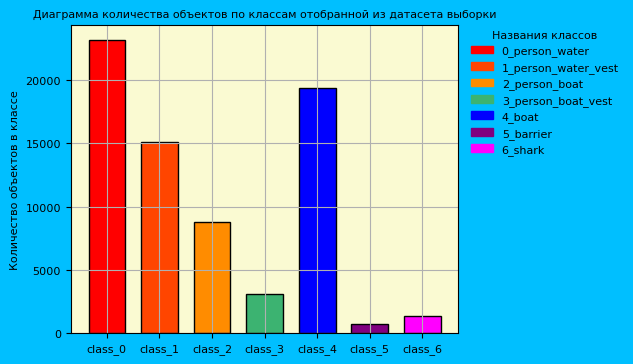



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



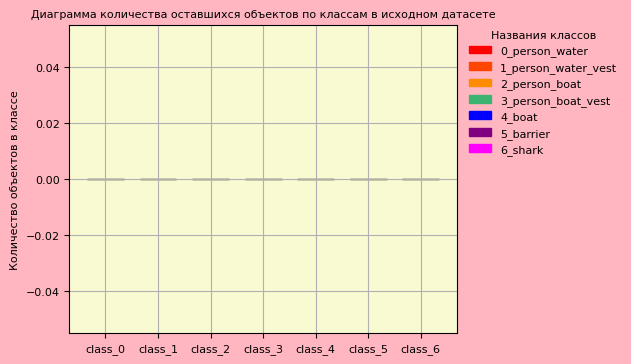


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                     0 |                        0
 1_person_water_vest |                     0 |                        0
 2_person_boat       |                     0 |                        0
 3_person_boat_vest  |                     0 |                        0
 4_boat              |                     0 |                        0
 5_barrier           |                     0 |                        0
 6_shark             |                     0 |                        0

--------------------------------------------
Общее количество объектов по всем классам: 0
Общее количество изображений: 8
Размер изображений датасета: 3.9 Мб
--------------------------------------------



In [34]:
# Копирование парсером аннотаций стратифицированной train выборки в отдельную папку

Total_balanceParser.get_balanced_samples(train_total_dataset_classes_objects_count_LIST,
                                         Total_train_labels_path,
                                         initial_avoid_file_names_list=None,
                                         keep_avoided=True,
                                         analysys_mode=False)

'''
Как видим на розовом графике, все аннотации отобраны и перемещены, больше нечего отбирать из исходного датасета.
Таблица статистики показывает, что объектов в датасете осталось 0 (больше нечего отбирать), но осталось 8 неотобранных изображений - это остались изображения у которых пустые аннотации, которые попали в датасет.
'''

# Анализ парсером итогового датасета Total_dataset (работа парсера в режиме анализа без копирование отобранных файлов аннотаций в указанную папку)

In [35]:
# метод сбрасывающий состояние парсера, обнуляет список уже отобранных файлов, чтобы парсер по новой смог делать их отбор с начала

Total_balanceParser.reset_avoided()

In [ ]:
# Перевод экземпляра парсера Total_balanceParser для Total_dataset в режим анализа (analysys_mode=True) 
# в котором не производится фактическое копирвоание файлов аннотаций отобранной выборки с заданными порогами, 
# но показываются какие получатся выборки (их статистики по кол-ву объектов, изображений и размеру)
# так же параметр keep_avoided переключается в False, при этом парсер не будет запоминат список уже отобранных файлов и каждый раз будет делать отбор без учета ранее отобранных файлов.


*****************************************
Статистика отобранной из датасета выборки
*****************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                  3751 |                      399
 1_person_water_vest |                   880 |                      155
 2_person_boat       |                   590 |                      232
 3_person_boat_vest  |                   531 |                      239
 4_boat              |                   847 |                      382
 5_barrier           |                   516 |                      278
 6_shark             |                   501 |                      342

-----------------------------------------------
Общее количество объектов по всем классам: 7616
Общее количество изображений: 859
Размер изображений д

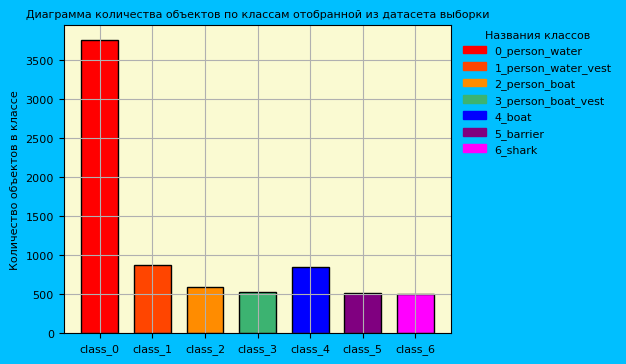



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



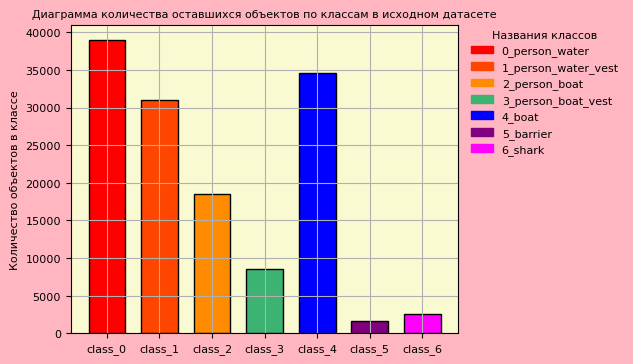


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 38962 |                    12698
 1_person_water_vest |                 30956 |                     9085
 2_person_boat       |                 18569 |                    10281
 3_person_boat_vest  |                  8598 |                     4098
 4_boat              |                 34545 |                    18326
 5_barrier           |                  1659 |                      921
 6_shark             |                  2628 |                     1796

-------------------------------------------------
Общее количество объектов по всем классам: 135917
Общее количество изображений: 27594
Размер изображений датасета: 11,724.7 Мб
-------------------------------------------------



In [37]:
# Отберем выборку, в которой порог минимум в 500 объектов на каждый класс, смотрим на полученную возможную комбинацию по кол-ву объектов на класс

Total_balanceParser.get_balanced_samples(500,
                                         None,
                                         initial_avoid_file_names_list=None,
                                         keep_avoided=False,
                                         analysys_mode=True)


'''
На синем графике ниже показана возможная выборка с таким порогом по каждому классу (возможная комбинация по объектам в выборке).
class_0 ушел в дисбаланс, как самый мажорный и часто встречающийся класс объектов на каждом изображении, его дисбаланс соответствует допущениям,
заложенным в алгоритме отбора, т.к. для данного датасета это максимально возможно близкая комбинация к пороговым значениями.
Все остальные классы получились по возможности предельно близкими к порогу в 500 объектов на класс.
На розовом графике при параметре keep_avoided=False будет всегда показываться статистика исходного датасета, т.к. парсер не запоминает отобранные файлы.
'''


*****************************************
Статистика отобранной из датасета выборки
*****************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 38962 |                    12698
 1_person_water_vest |                 18898 |                     4013
 2_person_boat       |                  5789 |                     3573
 3_person_boat_vest  |                  3373 |                     1453
 4_boat              |                 13243 |                     6270
 5_barrier           |                  1516 |                      834
 6_shark             |                   288 |                      287

------------------------------------------------
Общее количество объектов по всем классам: 82069
Общее количество изображений: 12698
Размер изображен

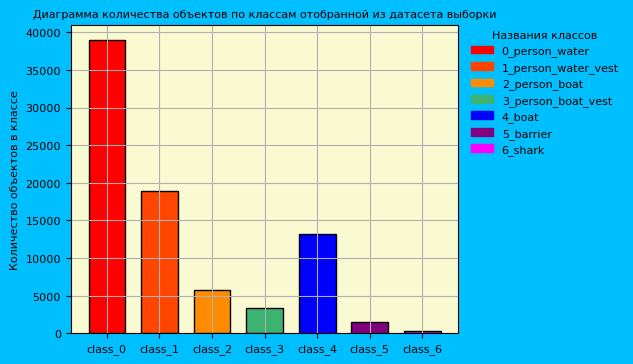



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



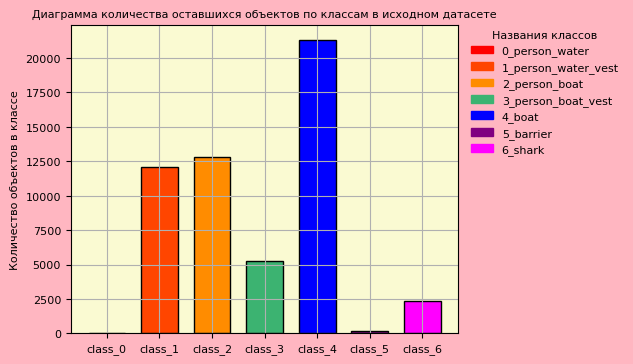


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                     0 |                        0
 1_person_water_vest |                 12058 |                     5072
 2_person_boat       |                 12780 |                     6708
 3_person_boat_vest  |                  5225 |                     2645
 4_boat              |                 21302 |                    12056
 5_barrier           |                   143 |                       87
 6_shark             |                  2340 |                     1509

------------------------------------------------
Общее количество объектов по всем классам: 53848
Общее количество изображений: 14896
Размер изображений датасета: 6,292.4 Мб
------------------------------------------------



In [38]:
# Отберем выборку, в которую заберем из датасета все объекты по классу 0_person_water, порог по этому классу - это все объекты этого класса 38962 шт., имеющиеся в датасете.
# Смотрим на полученную возможную комбинацию по кол-ву объектов на класс при такой выборке.
# Параметр keep_avoided переключили в True, чтобы увидеть какая выборка останется после полного удаления класса 0_person_water из датасета.

Total_balanceParser.get_balanced_samples([38962, 0, 0, 0, 0, 0, 0],
                                         None,
                                         initial_avoid_file_names_list=None,
                                         keep_avoided=True,
                                         analysys_mode=True)

'''
На синем графике ниже показана выборка, если отобрать весь класс 0_person_water из датасета,
а на розовом графике показана выборка, которая останется от исходного датасета, если из него извлечь все аннотации с объектами класса 0_person_water.
'''


*****************************************
Статистика отобранной из датасета выборки
*****************************************

                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 11278 |                      834
 1_person_water_vest |                     0 |                        0
 2_person_boat       |                    16 |                       15
 3_person_boat_vest  |                     1 |                        1
 4_boat              |                   163 |                       62
 5_barrier           |                  1659 |                      921
 6_shark             |                     0 |                        0

------------------------------------------------
Общее количество объектов по всем классам: 13117
Общее количество изображений: 921
Размер изображений

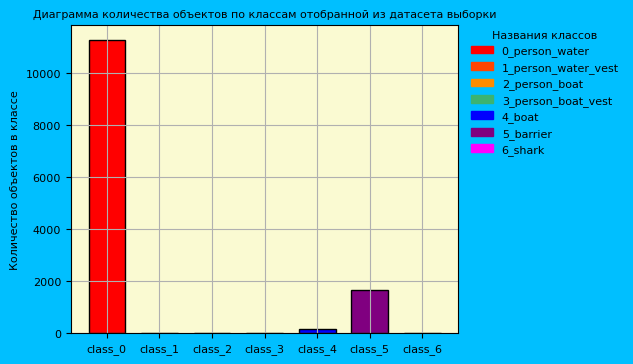



*************************************************************
Статистика по оставшимся объектам классов в исходном датасете
*************************************************************



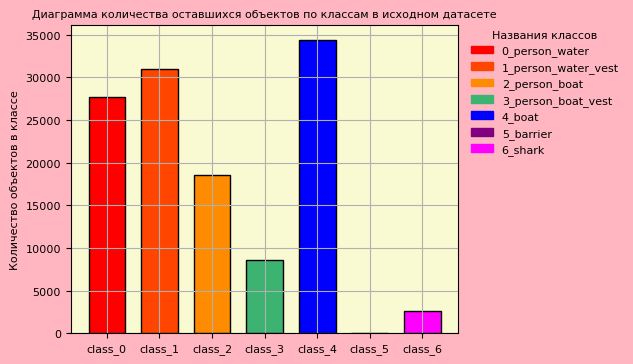


                     |   Количество объектов |         Общее количество
 Название класса     |            по классам |   изображений по классам
---------------------+-----------------------+--------------------------
 0_person_water      |                 27684 |                    11864
 1_person_water_vest |                 30956 |                     9085
 2_person_boat       |                 18553 |                    10266
 3_person_boat_vest  |                  8597 |                     4097
 4_boat              |                 34382 |                    18264
 5_barrier           |                     0 |                        0
 6_shark             |                  2628 |                     1796

-------------------------------------------------
Общее количество объектов по всем классам: 122800
Общее количество изображений: 26673
Размер изображений датасета: 11,315.7 Мб
-------------------------------------------------



In [39]:
# Заберем из датасета все объекты класса 5_barrier и проанализируем получившуюся выборку

Total_balanceParser.reset_avoided() # сбросим список ранее отобранных парсером файлов
Total_balanceParser.get_balanced_samples([0, 0, 0, 0, 0, 1659, 0],
                                          None,
                                          initial_avoid_file_names_list=None,
                                          keep_avoided=True,
                                          analysys_mode=True)

'''
Анализируем что будет, если удалить из датасета полностью минорный класс 5_barrier (буи).
Если извлечь из датасета файлы со всеми объектами класса 5_barrier (буи), которых в датасете 1659, 
то полученная выборка будет иметь объектов буев класса 5_barrier 1659 штук и людей в воде в количестве 11278 штук.
Это возможно только если на всех изображениях с буями условно есть один или пара буев и огромное количество людей в воде, 
что собственно так и есть, если посмотреть на данные. Таким образом можно выявилять и фиксировать перекосы в распределении данных в датасете.
'''